In [1]:
import torch
import random
import torchvision
import itertools
import numpy as np
from IPython.display import clear_output
import torch.nn as nn
import seaborn as sns
from einops import rearrange
from tqdm import tqdm
from random import Random
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import Resize, ToTensor
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms.functional import to_pil_image
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [2]:
Batch_size = 12

# DATASET

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Actual_train_dataset = torchvision.datasets.MNIST(root='./data',train=True,download = True,transform = transform)
Actual_test_dataset = torchvision.datasets.MNIST(root='./data',train = False,download = True,transform = transform)

In [4]:
classes_to_sample = [0,1,2]

In [5]:
train_samples = []
previous_train_indices = []
for cls in classes_to_sample:
  class_indices = [i for i,label in enumerate(Actual_train_dataset.targets) if label == cls]
  sampled_indices = np.random.choice(class_indices,100,replace = False)
  previous_train_indices.append(sampled_indices)
  # print(sampled_indices)
  sampled_images = torch.stack([Actual_train_dataset[i][0] for i in sampled_indices])
  train_samples.append(sampled_images)

train_samples = torch.cat(train_samples,dim=0)
# print(previous_train_indices)


In [6]:
test_samples=[]
previous_test_indices=[]
for cls in classes_to_sample:
  class_indices = [i for i,label in enumerate(Actual_test_dataset.targets) if label == cls]
  sampled_indices = np.random.choice(class_indices,100, replace = False)
  previous_test_indices.append(sampled_indices)
  sampled_images = torch.stack([Actual_test_dataset[i][0] for i in sampled_indices])
  test_samples.append(sampled_images)

test_samples = torch.cat(test_samples,dim=0)
print(len(test_samples))

300


Convert the datasets to pytorch TensorDatasets

In [7]:
train_labels = torch.cat([torch.full((100,),i) for i in [0,1,2]])
test_labels = torch.cat([torch.full((100,),i) for i in [0,1,2]])

train_dataset = TensorDataset(train_samples,train_labels)
test_dataset = TensorDataset(test_samples,test_labels)

In [8]:
train_loader = DataLoader(train_dataset,batch_size=Batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=Batch_size,shuffle=False)

# 1 a
VIT Blocks

In [9]:
img_size = 28  # MNIST images are 28x28
patch_size = 7  # As per the question
num_patches = (img_size // patch_size) ** 2  # Should be 16 for 28x28 images with 7x7 patches
embed_dim = 128  # As per the question
num_heads = 8
depth = 2
mlp_dim = 256
learning_rate = 0.001

In [10]:
class PatchEmbedding_conv(nn.Module):
  def __init__(self,img_size,patch_size,in_channels=1,embed_dim=128):
    super(PatchEmbedding_conv,self).__init__()
    self.patch_size = patch_size
    self.proj = nn.Conv2d(in_channels,embed_dim,kernel_size=patch_size,stride=patch_size)

  def forward(self,x):
    x = self.proj(x)
    x=rearrange(x,'b e h w -> b (h w) e')
    return x

patch_embedding = PatchEmbedding_conv(img_size,patch_size)
sample_image = next(iter(train_loader))[0][0].unsqueeze(0)
# sample_image = torch.randn(12,1,28,28)
# print(sample_image.shape)
patches = patch_embedding(sample_image)
print(patches.shape)


torch.Size([1, 16, 128])


MASKING

In [11]:
from os import pathconf_names
def mask_tokens(x, mask_ratio=0.5):
    """
    x: Tensor of shape (batch_size, num_patches, embed_dim)
    mask_ratio: The ratio of tokens to mask
    Returns:
        masked_x: Tensor with masked tokens replaced by zeros
        mask: Boolean mask indicating which tokens are masked
    """
    batch_size, num_patches, embed_dim = x.shape
    num_masked = int(num_patches * mask_ratio)
    mask = torch.zeros(batch_size, num_patches, dtype=torch.bool)

    for i in range(batch_size):
        masked_indices = random.sample(range(num_patches), num_masked)
        mask[i, masked_indices] = True

    masked_x = x.clone()
    masked_x[mask.unsqueeze(-1).expand_as(x)] = 0
    return masked_x, mask

x,y = mask_tokens(patches)

MultiHead Self Attention

In [12]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by the number of heads."
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape
        q = self.query(x).view(B, N, self.num_heads, self.head_dim)
        k = self.key(x).view(B, N, self.num_heads, self.head_dim)
        v = self.value(x).view(B, N, self.num_heads, self.head_dim)

        q, k, v = map(lambda t: rearrange(t, 'b n h d -> b h n d'), (q, k, v))

        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)

        attn = attn.softmax(dim=-1)
        # print(attn.shape)
        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        out = self.out(out)
        return out,attn

# Test Multi-Head Self-Attention
mhsa = MultiHeadSelfAttention(embed_dim=128, num_heads=8)
attn_output,attn = mhsa(patches)
# print(attn.shape)
print(attn_output.shape)  # Expected shape: (1, num_patches, embed_dim)


torch.Size([1, 16, 128])


Encoder Block

In [13]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0):
        super(TransformerEncoderBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mhsa = MultiHeadSelfAttention(embed_dim, num_heads)
        self.dropout1 = nn.Dropout(dropout)

        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout),
        )
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        attn_out,attn=self.mhsa(x)
        x = x + self.dropout1(attn_out)
        x = x + self.norm2(self.mlp(self.norm1(x)))
        return x

# Test Transformer Encoder Block
encoder_block = TransformerEncoderBlock(embed_dim=128, num_heads=8, mlp_dim=256)
encoded_output = encoder_block(attn_output)
print(encoded_output.shape)  # Expected shape: (1, num_patches, embed_dim)


torch.Size([1, 16, 128])


VIT by using MAE loss function.

In [14]:
class VisionTransformerMAE(nn.Module):
    def __init__(self, img_size=28, patch_size=7, embed_dim=128, depth=2, num_heads=8, mlp_dim=256, dropout=0.1):
        super(VisionTransformerMAE, self).__init__()
        self.patch_embedding = PatchEmbedding_conv(img_size, patch_size, in_channels=1, embed_dim=embed_dim)
        num_patches = (img_size // patch_size) ** 2  # Should be 16 for 28x28 images with 7x7 patches

        # Positional embedding without class token
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))
        self.dropout = nn.Dropout(dropout)

        self.encoder = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(depth)
        ])

        # Prediction head for reconstructing the masked patches
        self.prediction_head = nn.Linear(embed_dim, embed_dim)

    def forward_encoder(self, x):
        """
        Forward pass through the encoder.
        x: Input tensor of shape (batch_size, num_patches, embed_dim)
        """
        x = self.dropout(x)
        for encoder_block in self.encoder:
            x = encoder_block(x)
        return x

    def forward(self, x):
        # Apply the prediction head to all tokens
        x = self.prediction_head(self.forward_encoder(x))
        return x


MAE Loss function

In [15]:
def compute_mae_loss(predictions, targets, mask):
    """
    predictions: Tensor of shape (batch_size, num_patches, embed_dim)
    targets: Tensor of shape (batch_size, num_patches, embed_dim)
    mask: Boolean mask indicating which tokens were masked
    """
    loss_fn = nn.MSELoss()
    # Only compute loss on masked tokens
    # print(mask.unsqueeze(-1).expand_as(predictions))
    masked_predictions = predictions[mask.unsqueeze(-1).expand_as(predictions)]
    masked_targets = targets[mask.unsqueeze(-1).expand_as(targets)]
    loss = loss_fn(masked_predictions, masked_targets)
    return loss


Plot to see whether it is masking the 50% of the patches or not

In [16]:
# def plot_tensor_image(tensor, index=0):
#     """
#     Plots a single image from a tensor with shape (batch_size, height, width).

#     Args:
#         tensor (torch.Tensor): Input tensor of shape (batch_size, height, width).
#         index (int): Index of the image in the batch to plot.
#     """
#     # Ensure the tensor is on the CPU and detach if necessary
#     tensor = tensor.cpu().detach()

#     # Select the image at the specified index
#     image = tensor[index]

#     # Plot the image (considering it as a grayscale image)
#     plt.imshow(image, cmap='gray')
#     plt.title(f"Image from batch index {index}")
#     plt.show()

# # # Example usage with a tensor of shape (12, 16, 128)
# # tensor = torch.randn(12, 16, 128)
# # plot_tensor_image(tensor, index=0)  # Plots the first image in the batch


Initialize the model and optimizer

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model parameters
img_size = 28
patch_size = 7
embed_dim = 128
depth = 2
num_heads = 8
mlp_dim = 256
learning_rate = 0.001

mae_model = VisionTransformerMAE(
    img_size=img_size,
    patch_size=patch_size,
    embed_dim=embed_dim,
    depth=depth,
    num_heads=num_heads,
    mlp_dim=mlp_dim,
    dropout=0.1
).to(device)

optimizer = optim.Adam(mae_model.parameters(), lr=learning_rate)


MAE training pipeline

In [18]:
num_epochs = 10 # At least 10 epochs as per the question

for epoch in range(num_epochs):
    mae_model.train()
    total_loss = 0
    for batch in train_loader:
        images, _ = batch
        images = images.to(device)

        optimizer.zero_grad()

        # Step 1: Obtain patches and add positional encoding
        patches = mae_model.patch_embedding(images)  # Shape: (batch_size, num_patches, embed_dim)
        # plot_tensor_image(patches, index=0)
        patches += mae_model.pos_embedding  # Add positional encoding
        # plot_tensor_image(patches, index=0)

        # Step 2: Apply masking to patches
        masked_patches, mask = mask_tokens(patches, mask_ratio=0.5)
        masked_patches = masked_patches.to(device)
        # plot_tensor_image(masked_patches, index=0)
        mask = mask.to(device)


        # Step 3: Forward pass through the encoder
        encoded_patches = mae_model.forward_encoder(masked_patches)

        # Step 4: Apply the prediction head
        predictions = mae_model.prediction_head(encoded_patches)

        # Step 5: Compute the loss
        targets = patches  # Original patches with positional encoding
        loss = compute_mae_loss(predictions, targets, mask)

        # Step 6: Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 1.1966
Epoch [2/10], Loss: 0.9900
Epoch [3/10], Loss: 0.8969
Epoch [4/10], Loss: 0.8267
Epoch [5/10], Loss: 0.7688
Epoch [6/10], Loss: 0.7224
Epoch [7/10], Loss: 0.6844
Epoch [8/10], Loss: 0.6519
Epoch [9/10], Loss: 0.6245
Epoch [10/10], Loss: 0.5984


# 1 a classifier
Finetune the model for classification

In [19]:
class VisionTransformerClassifierMeanPool(nn.Module):
    def __init__(self, pretrained_model, num_classes=3):
        super(VisionTransformerClassifierMeanPool, self).__init__()
        self.encoder = pretrained_model.encoder  # Use the pretrained encoder (from MAE)
        self.patch_embedding = pretrained_model.patch_embedding
        self.pos_embedding = pretrained_model.pos_embedding  # Use positional embeddings from pretrained model
        self.dropout = pretrained_model.dropout

        embed_dim = pretrained_model.pos_embedding.shape[-1]

        # Classification head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)  # Output: number of classes
        )

    def forward(self, x):
        # Step 1: Patch Embedding
        x = self.patch_embedding(x)  # Shape: (batch_size, num_patches, embed_dim)

        # Step 2: Add Positional Encoding
        x += self.pos_embedding  # Add positional encodings to the patches
        x = self.dropout(x)

        # Step 3: Pass through transformer encoder blocks
        for encoder_block in self.encoder:
            x = encoder_block(x)

        # Step 4: Mean Pooling (instead of CLS token)
        x = x.mean(dim=1)  # Mean pooling over all the patch tokens

        # Step 5: Pass through classification head
        x = self.mlp_head(x)  # Shape: (batch_size, num_classes)
        return x


Initialize the classifier model

In [20]:
selected_classes = classes_to_sample
classifier_model = VisionTransformerClassifierMeanPool(mae_model, num_classes=len(selected_classes)).to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=learning_rate)


Finetuning pipeline

In [21]:
num_finetune_epochs = 10

for epoch in range(num_finetune_epochs):
    classifier_model.train()
    total_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = classifier_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Finetune Epoch [{epoch + 1}/{num_finetune_epochs}], Loss: {avg_loss:.4f}")


Finetune Epoch [1/10], Loss: 0.7585
Finetune Epoch [2/10], Loss: 0.2919
Finetune Epoch [3/10], Loss: 0.1690
Finetune Epoch [4/10], Loss: 0.0828
Finetune Epoch [5/10], Loss: 0.1020
Finetune Epoch [6/10], Loss: 0.1613
Finetune Epoch [7/10], Loss: 0.1201
Finetune Epoch [8/10], Loss: 0.0387
Finetune Epoch [9/10], Loss: 0.0487
Finetune Epoch [10/10], Loss: 0.0380


Evaluate the model on Test dataset

In [22]:
classifier_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = classifier_model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# 1a Accuracy and confusion Matrix
Test Accuracy and Confusion Matrix

Test Accuracy: 98.00%
Confusion Matrix:
[[98  0  2]
 [ 0 98  2]
 [ 2  0 98]]


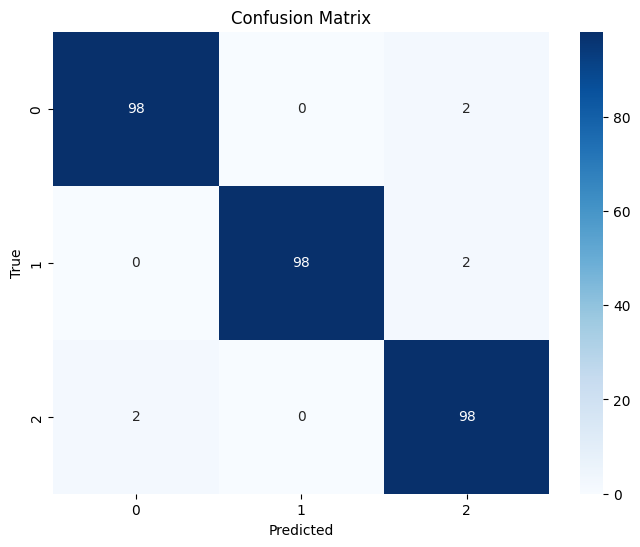

In [23]:
# Compute accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# 1 b - VIT with cls token


In [24]:
class VisionTransformerWithCLS(nn.Module):
    def __init__(self, img_size=28, patch_size=7, embed_dim=128, depth=2, num_heads=8, mlp_dim=256, dropout=0.1):
        super(VisionTransformerWithCLS, self).__init__()
        self.patch_embedding = PatchEmbedding_conv(img_size, patch_size, in_channels=1, embed_dim=embed_dim)
        num_patches = (img_size // patch_size) ** 2  # Should be 16 for 28x28 images with 7x7 patches

        # Initialize class token and positional embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))  # +1 for CLS token
        self.dropout = nn.Dropout(dropout)

        # Transformer encoder blocks
        self.encoder = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(depth)
        ])

    def forward(self, x):
        x = self.patch_embedding(x)  # Shape: (batch_size, num_patches, embed_dim)

        batch_size = x.shape[0]
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # Shape: (batch_size, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # Now x has shape (batch_size, num_patches + 1, embed_dim)

        x += self.pos_embedding
        x = self.dropout(x)

        for encoder_block in self.encoder:
            x = encoder_block(x)

        return x  # Return all tokens including CLS token


InfoNCE Loss

In [25]:
def info_nce_loss(features, labels, temperature=0.5):
    """
    Compute the InfoNCE loss for a batch of features.

    features: Tensor of shape (batch_size, embed_dim)
    labels: Tensor of shape (batch_size)
    temperature: Temperature parameter for scaling.

    Returns:
        loss: Scalar tensor representing the loss.
    """
    batch_size = features.shape[0]
    # Normalize features
    features = F.normalize(features, dim=1)

    # Compute similarity matrix
    similarity_matrix = torch.matmul(features, features.T)  # Shape: (batch_size, batch_size)
    similarity_matrix = similarity_matrix / temperature

    # Create labels for InfoNCE loss
    labels = labels.contiguous().view(-1, 1)  # Shape: (batch_size, 1)
    mask = torch.eq(labels, labels.T).float().to(features.device)  # Shape: (batch_size, batch_size)

    # Remove self-similarity
    logits_mask = torch.ones_like(mask) - torch.eye(batch_size).to(features.device)
    mask = mask * logits_mask

    # Compute log probabilities
    exp_sim = torch.exp(similarity_matrix) * logits_mask
    log_prob = similarity_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-8)

    # Compute mean of log-likelihood over positive samples
    mean_log_prob_pos = (mask * log_prob).sum(dim=1) / (mask.sum(dim=1) + 1e-8)

    # Loss
    loss = -mean_log_prob_pos.mean()

    return loss


Intializing the model and parameters and optimizer

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model parameters
img_size = 28
patch_size = 7
embed_dim = 128
depth = 2
num_heads = 8
mlp_dim = 256
learning_rate = 0.001

# Initialize the model
vit_model = VisionTransformerWithCLS(
    img_size=img_size,
    patch_size=patch_size,
    embed_dim=embed_dim,
    depth=depth,
    num_heads=num_heads,
    mlp_dim=mlp_dim,
    dropout=0.1
).to(device)

optimizer = optim.Adam(vit_model.parameters(), lr=learning_rate)


Training pipeline

In [27]:
import torch.nn.functional as F

num_epochs = 10  # At least 10 epochs as per the question

for epoch in range(num_epochs):
    vit_model.train()
    total_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = vit_model(images)  # Shape: (batch_size, num_patches + 1, embed_dim)
        cls_tokens = outputs[:, 0]  # Extract CLS token representations

        # Compute InfoNCE loss
        loss = info_nce_loss(cls_tokens, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 2.1687
Epoch [2/10], Loss: 1.8095
Epoch [3/10], Loss: 1.6822
Epoch [4/10], Loss: 1.5964
Epoch [5/10], Loss: 1.6806
Epoch [6/10], Loss: 1.8883
Epoch [7/10], Loss: 1.6188
Epoch [8/10], Loss: 1.4424
Epoch [9/10], Loss: 1.4506
Epoch [10/10], Loss: 1.4340


Finetuning the Model for classificaiton

In [28]:
class VisionTransformerClassifierWithCLS(nn.Module):
    def __init__(self, pretrained_model, num_classes=3):
        super(VisionTransformerClassifierWithCLS, self).__init__()
        self.encoder = pretrained_model.encoder  # Use the pretrained encoder
        self.patch_embedding = pretrained_model.patch_embedding
        self.cls_token = pretrained_model.cls_token
        self.pos_embedding = pretrained_model.pos_embedding
        self.dropout = pretrained_model.dropout

        # Classification head
        embed_dim = pretrained_model.cls_token.shape[-1]
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        x = self.patch_embedding(x)  # Shape: (batch_size, num_patches, embed_dim)

        batch_size = x.shape[0]
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # Shape: (batch_size, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # Now x has shape (batch_size, num_patches + 1, embed_dim)

        x += self.pos_embedding
        x = self.dropout(x)

        for encoder_block in self.encoder:
            x = encoder_block(x)

        # Classification is based on the class token
        x = self.mlp_head(x[:, 0])  # Use the class token representation
        return x


Initialize the classifier model

In [29]:
classifier_model = VisionTransformerClassifierWithCLS(vit_model, num_classes=len(selected_classes)).to(device)

# Define the optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=learning_rate)


Finetuning pipeline

In [30]:
num_finetune_epochs = 10  # You can adjust this

for epoch in range(num_finetune_epochs):
    classifier_model.train()
    total_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = classifier_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Finetune Epoch [{epoch + 1}/{num_finetune_epochs}], Loss: {avg_loss:.4f}")


Finetune Epoch [1/10], Loss: 0.2100
Finetune Epoch [2/10], Loss: 0.1551
Finetune Epoch [3/10], Loss: 0.0582
Finetune Epoch [4/10], Loss: 0.0506
Finetune Epoch [5/10], Loss: 0.0696
Finetune Epoch [6/10], Loss: 0.0540
Finetune Epoch [7/10], Loss: 0.0415
Finetune Epoch [8/10], Loss: 0.0203
Finetune Epoch [9/10], Loss: 0.0172
Finetune Epoch [10/10], Loss: 0.0196


Evaluating the model on the test dataset

In [31]:
classifier_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = classifier_model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# 1b Accuracy and Confusion Matrix
Test accuracy and confusion matrix

Test Accuracy: 97.33%
Confusion Matrix:
[[ 96   0   4]
 [  0 100   0]
 [  2   2  96]]


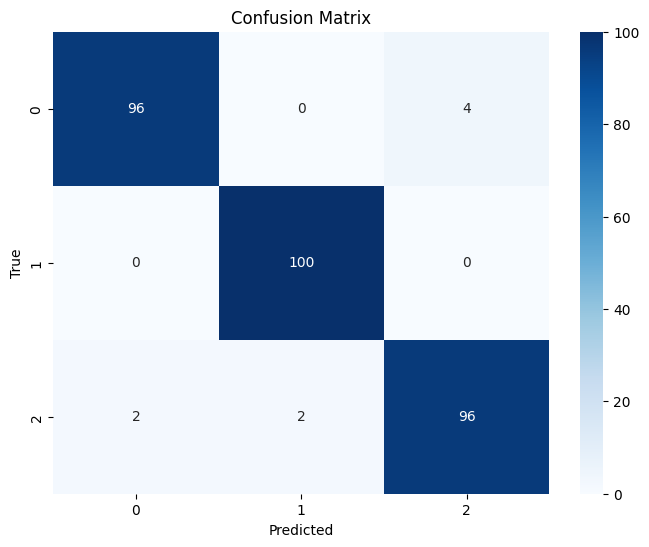

In [32]:
# Compute accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 1 c VIT with MAE and InfoNCE

In [33]:
class VisionTransformerMAEInfoNCE(nn.Module):
    def __init__(self, img_size=28, patch_size=7, embed_dim=128, depth=2, num_heads=8, mlp_dim=256, dropout=0.1):
        super(VisionTransformerMAEInfoNCE, self).__init__()
        self.patch_embedding = PatchEmbedding_conv(img_size, patch_size, in_channels=1, embed_dim=embed_dim)
        num_patches = (img_size // patch_size) ** 2  # Should be 16 for 28x28 images with 7x7 patches

        # Initialize CLS token and positional embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))  # +1 for CLS token
        self.dropout = nn.Dropout(dropout)

        # Transformer encoder
        self.encoder = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(depth)
        ])

        # MAE reconstruction head
        self.prediction_head = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, mask=None):
        # Patch Embedding
        x = self.patch_embedding(x)  # Shape: (batch_size, num_patches, embed_dim)

        batch_size = x.shape[0]
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # Shape: (batch_size, 1, embed_dim)

        # Append CLS token
        x = torch.cat((cls_tokens, x), dim=1)  # Now x has shape (batch_size, num_patches + 1, embed_dim)

        # Add positional embeddings
        x += self.pos_embedding
        x = self.dropout(x)

        # Pass through transformer encoder
        for encoder_block in self.encoder:
            x = encoder_block(x)

        # Separate CLS token and patch tokens
        cls_token = x[:, 0]  # CLS token
        patch_tokens = x[:, 1:]  # Patch tokens

        if mask is not None:
            # Return predicted patch embeddings for MAE
            return cls_token, self.prediction_head(patch_tokens)

        # If no mask, just return CLS token and patch tokens
        return cls_token, patch_tokens


Combined Loss

In [34]:
def combined_loss(cls_token, patches, predictions, targets, mask, labels, mae_weight=0.8, info_nce_weight=0.2):
    # Compute MAE loss (only on masked patches)
    mae_loss = compute_mae_loss(predictions, targets, mask)

    # Compute InfoNCE loss (on CLS token)
    info_nce_loss_value = info_nce_loss(cls_token, labels)

    # Combine the two losses with specified weights
    return mae_weight * mae_loss + info_nce_weight * info_nce_loss_value



Initilizing Model , parameters and optimizer

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model parameters
img_size = 28
patch_size = 7
embed_dim = 128
depth = 2
num_heads = 8
mlp_dim = 256
learning_rate = 0.001

# Initialize the model
MAEInfoNCE_model = VisionTransformerMAEInfoNCE(
    img_size=img_size,
    patch_size=patch_size,
    embed_dim=embed_dim,
    depth=depth,
    num_heads=num_heads,
    mlp_dim=mlp_dim,
    dropout=0.1
).to(device)

# Optimizer
optimizer = optim.Adam(MAEInfoNCE_model.parameters(), lr=learning_rate)

Training Pipeline

In [36]:


# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    MAEInfoNCE_model.train()
    total_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Obtain patches and add positional encoding
        patches = MAEInfoNCE_model.patch_embedding(images)
        patches += MAEInfoNCE_model.pos_embedding[:, 1:]  # Ignore the CLS token for patch embeddings

        # Mask tokens for MAE
        masked_patches, mask = mask_tokens(patches, mask_ratio=0.5)
        masked_patches = masked_patches.to(device)
        mask = mask.to(device)

        # Forward pass through the model
        cls_token, recon_patches = MAEInfoNCE_model(images, mask=mask)

        # Compute the combined loss (MAE + InfoNCE)
        mae_target = patches  # The original, unmasked patches
        loss = combined_loss(cls_token, patches, recon_patches, mae_target, mask, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 1.0473
Epoch [2/10], Loss: 0.6121
Epoch [3/10], Loss: 0.5699
Epoch [4/10], Loss: 0.5566
Epoch [5/10], Loss: 0.5290
Epoch [6/10], Loss: 0.4693
Epoch [7/10], Loss: 0.4342
Epoch [8/10], Loss: 0.4111
Epoch [9/10], Loss: 0.3975
Epoch [10/10], Loss: 0.3706


Using Pretrained Network and finetuning it on the same dataset by removing the prediction head.

In [37]:
class VisionTransformerClassifier(nn.Module):
    def __init__(self, pretrained_model, num_classes=3):
        super(VisionTransformerClassifier, self).__init__()
        self.encoder = pretrained_model.encoder  # Use the pretrained encoder
        self.patch_embedding = pretrained_model.patch_embedding
        self.pos_embedding = pretrained_model.pos_embedding
        self.cls_token = pretrained_model.cls_token
        self.dropout = pretrained_model.dropout

        # Classification head
        embed_dim = pretrained_model.cls_token.shape[-1]
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        # Patch embedding and CLS token
        x = self.patch_embedding(x)
        batch_size = x.shape[0]

        # Use self.cls_token instead of pretrained_model.cls_token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)

        # Concatenate CLS token and patch tokens
        x = torch.cat((cls_tokens, x), dim=1)

        # Add positional embeddings and dropout
        x += self.pos_embedding
        x = self.dropout(x)

        # Pass through transformer encoder
        for encoder_block in self.encoder:
            x = encoder_block(x)

        # CLS token for classification
        cls_token = x[:, 0]  # Use CLS token
        x = self.mlp_head(cls_token)
        return x


In [38]:
# Initialize the finetuning model using the pretrained model
finetune_model = VisionTransformerClassifier(pretrained_model=MAEInfoNCE_model, num_classes=3).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(finetune_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Fine-tuning loop
num_finetune_epochs = 10

for epoch in range(num_finetune_epochs):
    finetune_model.train()
    total_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = finetune_model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_finetune_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 0.2422
Epoch [2/10], Loss: 0.1536
Epoch [3/10], Loss: 0.0771
Epoch [4/10], Loss: 0.0941
Epoch [5/10], Loss: 0.0780
Epoch [6/10], Loss: 0.0430
Epoch [7/10], Loss: 0.0424
Epoch [8/10], Loss: 0.0417
Epoch [9/10], Loss: 0.0911
Epoch [10/10], Loss: 0.0863


# 1c Accuracy and Confusion Matrix
Test Accuracy and Confusion Matrix

Test Accuracy: 97.67%
Confusion Matrix:
[[99  0  1]
 [ 0 99  1]
 [ 5  0 95]]


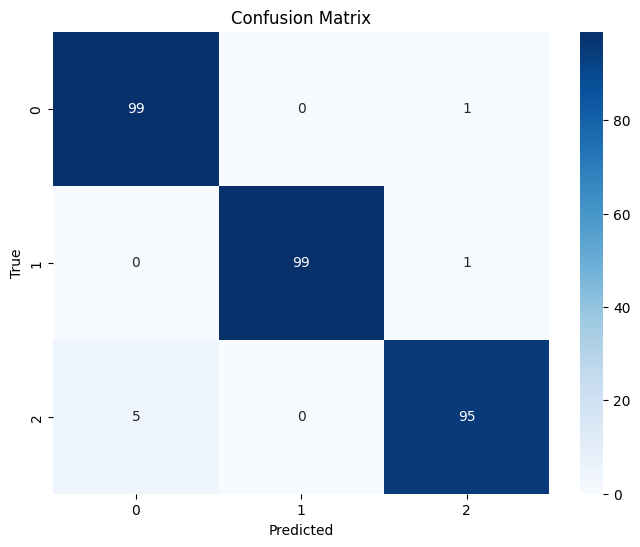

In [40]:
# Evaluation on test data
finetune_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = finetune_model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 1d


In [41]:


class VideoPatchEmbedding(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, embed_dim=128):
        super(VideoPatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, frames):
        # frames: (batch_size, num_frames, in_channels, height, width)
        batch_size, num_frames, in_channels, height, width = frames.shape

        # Apply Conv2d to each frame independently and reshape the patches
        patches = []
        for t in range(num_frames):
            patch_embeddings = self.proj(frames[:, t])  # Shape: (batch_size, embed_dim, num_patches_h, num_patches_w)
            patches.append(rearrange(patch_embeddings, 'b e h w -> b (h w) e'))  # Shape: (batch_size, num_patches, embed_dim)

        # Concatenate tokens from all frames
        patches = torch.cat(patches, dim=1)  # Shape: (batch_size, num_patches * num_frames, embed_dim)
        return patches


In [42]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_patches, embed_dim, num_frames):
        super(PositionalEncoding, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches * num_frames, embed_dim))

    def forward(self, x):
        # x: (batch_size, num_patches * num_frames, embed_dim)
        return x + self.pos_embedding


In [43]:
import random

def shuffle_and_mask(tokens, mask_ratio=0.85):
    # tokens: (batch_size, num_tokens, embed_dim)
    batch_size, num_tokens, embed_dim = tokens.shape
    num_masked = int(num_tokens * mask_ratio)

    # Shuffle token indices
    shuffled_indices = torch.randperm(num_tokens)

    # Separate masked and unmasked tokens
    unmasked_indices = shuffled_indices[:num_tokens - num_masked]
    masked_indices = shuffled_indices[num_tokens - num_masked:]

    unmasked_tokens = tokens[:, unmasked_indices]

    # Masked tokens will be appended later during decoding
    return unmasked_tokens, masked_indices, unmasked_indices


In [44]:
class VisionTransformerEncoder(nn.Module):
    def __init__(self, embed_dim, depth=2, num_heads=8, mlp_dim=256, dropout=0.1):
        super(VisionTransformerEncoder, self).__init__()
        self.encoder = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(depth)
        ])

    def forward(self, x):
        for encoder_block in self.encoder:
            x = encoder_block(x)
        return x


In [45]:
class VideoMAEDecoder(nn.Module):
    def __init__(self, embed_dim):
        super(VideoMAEDecoder, self).__init__()
        self.decoder = nn.Linear(embed_dim, embed_dim)

    def forward(self, encoded_tokens, masked_indices, unmasked_indices, batch_size, num_tokens):
        # Create a placeholder for all tokens
        all_tokens = torch.zeros(batch_size, num_tokens, encoded_tokens.shape[-1]).to(encoded_tokens.device)

        # Fill the unmasked tokens in their original positions
        all_tokens[:, unmasked_indices] = encoded_tokens

        # Decode the masked tokens
        all_tokens = self.decoder(all_tokens)
        return all_tokens


In [46]:
def video_mae_loss(reconstructed_tokens, original_tokens):
    # L1 loss between reconstructed tokens and original tokens
    loss_fn = nn.L1Loss()
    return loss_fn(reconstructed_tokens, original_tokens)


In [48]:
# Initialize the models
embed_dim = 128
num_patches = 4 * 4  # Assuming each frame is divided into 4x4 patches
num_frames = 3

patch_embedding = VideoPatchEmbedding(img_size=28, patch_size=7, embed_dim=embed_dim).to(device)
positional_encoding = PositionalEncoding(num_patches, embed_dim, num_frames).to(device)
encoder = VisionTransformerEncoder(embed_dim).to(device)
decoder = VideoMAEDecoder(embed_dim).to(device)

optimizer = torch.optim.Adam(list(patch_embedding.parameters()) +
                             list(positional_encoding.parameters()) +
                             list(encoder.parameters()) +
                             list(decoder.parameters()), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    patch_embedding.train()
    total_loss = 0

    for video_frames, _ in train_loader:
        video_frames = video_frames.to(device)
        # Assuming `video_frames` is a 4D tensor (batch_size, in_channels, height, width)

        # Simulating video frames by repeating the same frame 3 times (for example)
        num_frames = 3
        video_frames = video_frames.unsqueeze(1).repeat(1, num_frames, 1, 1, 1)  # Shape: (batch_size, num_frames, in_channels, height, width)


        optimizer.zero_grad()

        # Step 1: Obtain tokens from video frames
        tokens = patch_embedding(video_frames)

        # Step 2: Add positional encoding
        tokens = positional_encoding(tokens)

        # Step 3: Shuffle and mask tokens
        unmasked_tokens, masked_indices, unmasked_indices = shuffle_and_mask(tokens, mask_ratio=0.85)

        # Step 4: Feed unmasked tokens into the encoder
        encoded_tokens = encoder(unmasked_tokens)

        # Step 5: Inverse shuffle and append masked tokens, then decode
        reconstructed_tokens = decoder(encoded_tokens, masked_indices, unmasked_indices, video_frames.size(0), tokens.size(1))

        # Step 6: Compute L1 loss for MAE
        loss = video_mae_loss(reconstructed_tokens, tokens)

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 0.8400
Epoch [2/10], Loss: 0.7333
Epoch [3/10], Loss: 0.6843
Epoch [4/10], Loss: 0.6514
Epoch [5/10], Loss: 0.6247
Epoch [6/10], Loss: 0.6034
Epoch [7/10], Loss: 0.5815
Epoch [8/10], Loss: 0.5637
Epoch [9/10], Loss: 0.5456
Epoch [10/10], Loss: 0.5281


Finetunning

In [51]:
class VideoMAEClassifier(nn.Module):
    def __init__(self, patch_embedding, positional_encoding, encoder, num_classes=3):
        super(VideoMAEClassifier, self).__init__()

        # Use the pretrained patch embedding, positional encoding, and encoder
        self.patch_embedding = patch_embedding
        self.positional_encoding = positional_encoding
        self.encoder = encoder

        # Classification head (after mean pooling the tokens)
        embed_dim = patch_embedding.proj.out_channels  # Same as the output of the patch embedding
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)  # Output: number of classes
        )

    def forward(self, frames):
        # Tokenize the input video frames
        tokens = self.patch_embedding(frames)

        # Add positional encoding
        tokens = self.positional_encoding(tokens)

        # Feed to the encoder (no masking during fine-tuning)
        encoded_tokens = self.encoder(tokens)

        # Mean Pooling the encoded tokens (get the global representation of the video)
        global_rep = encoded_tokens.mean(dim=1)  # Shape: (batch_size, embed_dim)

        # Feed the global representation to the classification head
        logits = self.mlp_head(global_rep)
        return logits


In [54]:
# Reuse the components from the pretraining step
patch_embedding = patch_embedding  # Reuse the patch embedding from pretraining
positional_encoding = positional_encoding  # Reuse the positional encoding from pretraining
encoder = encoder  # Reuse the pretrained encoder from pretraining

# Initialize the fine-tuning model with the pretrained components
num_classes = 3  # Adjust this to match your number of classes
finetune_model = VideoMAEClassifier(patch_embedding, positional_encoding, encoder, num_classes=num_classes).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(finetune_model.parameters(), lr=0.001)  # Train all parameters

# Fine-tuning loop
num_finetune_epochs = 10

for epoch in range(num_finetune_epochs):
    finetune_model.train()  # Set the model to training mode
    total_loss = 0

    for video_frames, labels in train_loader:
        video_frames = video_frames.to(device)
        num_frames = 3
        video_frames = video_frames.unsqueeze(1).repeat(1, num_frames, 1, 1, 1)

        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = finetune_model(video_frames)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_finetune_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 1.3793
Epoch [2/10], Loss: 1.0230
Epoch [3/10], Loss: 0.7025
Epoch [4/10], Loss: 0.4331
Epoch [5/10], Loss: 0.2370
Epoch [6/10], Loss: 0.1990
Epoch [7/10], Loss: 0.1607
Epoch [8/10], Loss: 0.0793
Epoch [9/10], Loss: 0.0521
Epoch [10/10], Loss: 0.0530


Test Accuracy: 96.33%
Confusion Matrix:
[[100   0   0]
 [  1  96   3]
 [  7   0  93]]


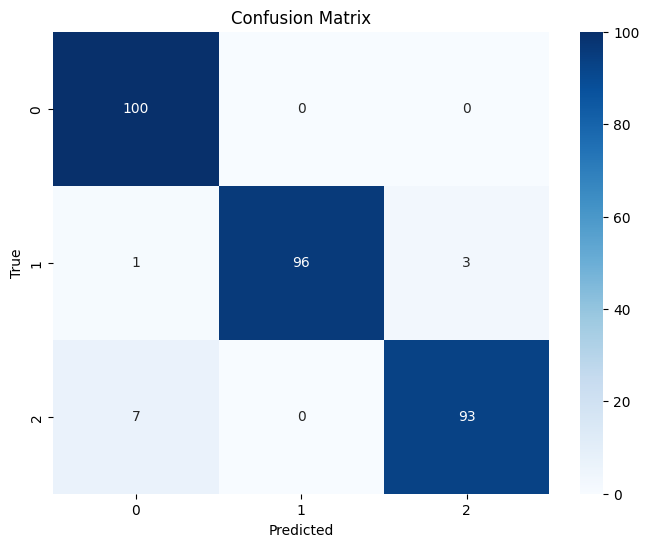

In [56]:
# Testing and accuracy calculation
finetune_model.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation for testing
    for video_frames, labels in test_loader:
        video_frames = video_frames.to(device)
        num_frames = 3
        video_frames = video_frames.unsqueeze(1).repeat(1, num_frames, 1, 1, 1)
        labels = labels.to(device)

        # Forward pass
        outputs = finetune_model(video_frames)

        # Get predictions
        _, preds = torch.max(outputs, 1)

        # Collect predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute test accuracy
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
